In [46]:
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from __future__ import (division, 
                        print_function)

import os
import sys
import copy
import fnmatch
import warnings
import collections

import numpy as np
import scipy
try:
    from scipy.stats import scoreatpercentile
except:
    scoreatpercentile = False
from scipy.interpolate import interp1d
import cPickle as pickle

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
from astropy.table import Table, Column
from astropy.table import vstack
from astropy.utils.console import ProgressBar
from astropy.convolution import convolve, Box1DKernel

# AstroML
from astroML.plotting import hist
from astroML.density_estimation import KNeighborsDensity
try:
    from sklearn.neighbors import KernelDensity
    use_sklearn_KDE = True
except:
    import warnings
    warnings.warn("KDE will be removed in astroML version 0.3.  Please "
                  "upgrade to scikit-learn 0.14+ and use "
                  "sklearn.neighbors.KernelDensity.", DeprecationWarning)
    from astroML.density_estimation import KDE
    use_sklearn_KDE = False
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

# Matplotlib related
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
tickFormat = FormatStrFormatter('$\mathbf{%g}$') 

# Personal
import hscUtils as hUtil
import hscSMHM
#import galSBP

# Cosmology
import cosmology
c=cosmology.Cosmo(H0=70.0, omega_m=0.3, omega_l=0.7, flat=1)

import colossus

import emcee
import corner

# Color map 
from palettable.colorbrewer.sequential import Greys_9, OrRd_9, Blues_9, Purples_9, YlGn_9
BLK = Greys_9.mpl_colormap
ORG = OrRd_9.mpl_colormap
BLU = Blues_9.mpl_colormap
GRN = YlGn_9.mpl_colormap
PUR = Purples_9.mpl_colormap

# Personal tools
from hscUtils import songPlotSetup, removeIsNullCol
from hscUtils import confidence_interval, ma_confidence_interval_1d, confidence_interval_1d

## Constants
# SDSS pivot wavelength 
sdss_u_pivot = 3551.0
sdss_g_pivot = 4686.0
sdss_r_pivot = 6165.0
sdss_i_pivot = 7481.0
sdss_z_pivot = 8931.0

# HSC pivot wavelength 
hsc_g_pivot = 4782.2
hsc_r_pivot = 6101.7 
hsc_i_pivot = 7648.0 
hsc_z_pivot = 8883.0
hsc_y_pivot = 9750.8

hscFiltWave = np.asarray([hsc_g_pivot, hsc_r_pivot, hsc_i_pivot, hsc_z_pivot, hsc_y_pivot])

"""
Absolute magnitude of the Sun in HSC filters
Right now, just use the DES filters
"""
SUN_G = 5.08
SUN_R = 4.62
SUN_I = 4.52
SUN_Z = 4.52
SUN_Y = 4.51

# Solar stellar metallicity 
Z_SUN = 0.02

# definitions for the axes
left, width    = 0.15, 0.64
right          = left + width 
bottom, height = 0.13, 0.86
bottom_h = left_h = left + width + 0.02
recScat = [left,   bottom, width, height]
recHist = [right,  bottom,  0.20, height]
SBP1 = [0.124, 0.085, 0.865, 0.33]
SBP2 = [0.124, 0.41, 0.865, 0.55]
EC1 = [0.135, 0.072, 0.862, 0.295]
EC2 = [0.135, 0.366, 0.862, 0.295]
EC3 = [0.135, 0.666, 0.862, 0.295]
REC = [0.12, 0.11, 0.87, 0.87]
COG1 = [0.143, 0.10, 0.850, 0.43]
COG2 = [0.143, 0.53, 0.850, 0.43]

# Universal RSMA array
RSMA_COMMON = np.arange(0.4, 4.2, 0.01)
RR50_COMMON = np.arange(0.0, 9.0, 0.01)
EMPTY = (RSMA_COMMON * np.nan)

# Color 
BLUE0 = "#92c5de"
BLUE1 = "#0571b0"
RED0 = "#f4a582"
RED1 = "#ca0020"
PURPLE0 = '#af8dc3'
PURPLE1 = '#762a83'
BROWN0 = '#bf812d'
BROWN1 = '#543005'
GREEN0 = '#7fbf7b'
GREEN1 = '#1b7837'

# 3-sigma
SIGMA1 = 0.3173
SIGMA2 = 0.0455
SIGMA3 = 0.0027

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in the catalogs

In [2]:
# Location of the data
homeDir = os.getenv('HOME')
sbpDir = os.path.join(homeDir, 'astro4/massive/dr15b/sbp/')
#sbpDir = os.path.join(homeDir, 'work/massive/dr15b/sbp/')

# Location for figures
figDir = os.path.join(sbpDir, 'figure')
# Location for subsamples
sampleDir = os.path.join(sbpDir, 'catalog')

masterDir = os.path.join(homeDir, 'astro4/massive/dr15b/master')
#masterDir = os.path.join(homeDir, 'work/massive/dr15b/master')

# The SED models 
# 'fsps1', 'fsps2', 'fsps3', 'fsps4', 'bc03a'
sedMod = 'fsps1'
# 'imgsub', 'img'
sbpType = 'imgsub'

# Catalog files for BCG and NonBCG
redbcgStr = 'dr1_redbcg_isedfit_mass_' + sedMod + '_sbpsum_' + sbpType + '_use'
nonbcgStr = 'dr1_nonbcg_isedfit_mass_' + sedMod + '_sbpsum_' + sbpType + '_use'
redmemStr = 'dr1_redmem_isedfit_mass_' + sedMod + '_sbpsum_' + sbpType + '_use'

redbcgFile = redbcgStr + '.fits' 
nonbcgFile = nonbcgStr + '.fits' 
redmemFile = redmemStr + '.fits'

# Output
redbcgPrep = redbcgFile.replace('.fits', '_prep.fits')
nonbcgPrep = nonbcgFile.replace('.fits', '_prep.fits')
redmemPrep = redmemFile.replace('.fits', '_prep.fits')

redbcgLab1 = '$\mathrm{cenLowMh}$'
redbcgLab2 = '$\mathrm{cenHighMh}$'
nonbcgLab = '$\mathrm{cenLowMh}$'

try:
    redbcgTab
except NameError:
    pass
else:
    del redbcgTab     
try:
    nonbcgTab
except NameError:
    pass
else:
    del nonbcgTab
    
# Location for the SBP summary file
redbcgDir = os.path.join(sbpDir, 'redbcg')
nonbcgDir = os.path.join(sbpDir, 'nonbcg')
redmemDir = os.path.join(sbpDir, 'redmem')

# Two summary catalogs
redbcgCat = os.path.join(sampleDir, redbcgFile)
nonbcgCat = os.path.join(sampleDir, nonbcgFile)
redmemCat = os.path.join(sampleDir, redmemFile)

prefix1 = 'redbcg'
prefix2 = 'nonbcg'
prefix3 = 'redmem'

In [3]:
# The CLEAN sample: 
redbcgClean = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_clean.fits')), 
                         format='fits')
nonbcgClean = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_clean.fits')), 
                         format='fits')
redmemClean = Table.read(os.path.join(sampleDir, redmemFile.replace('.fits', '_clean.fits')), 
                         format='fits')

# The USE samples: 
redbcgUse = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_use.fits')), 
                         format='fits')
nonbcgUse = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_use.fits')), 
                         format='fits')
redmemUse = Table.read(os.path.join(sampleDir, redmemFile.replace('.fits', '_use.fits')), 
                         format='fits')

# The GAMA sample
redbcgGama = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_gama.fits')), 
                        format='fits')
nonbcgGama = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_gama.fits')), 
                        format='fits')

redbcgGamaZ = Table.read(os.path.join(sampleDir, redbcgFile.replace('.fits', '_gamaz.fits')), 
                         format='fits')
nonbcgGamaZ = Table.read(os.path.join(sampleDir, nonbcgFile.replace('.fits', '_gamaz.fits')), 
                         format='fits')

# Stripe 82 
s82data = Table.read(os.path.join(masterDir, 'dr1_s82_clean_zbin_isedfit_fsps2.fits'), 
                     format='fits')

In [4]:
redbcgCleanU = redbcgClean[redbcgClean['z_use'] > 0.3]
nonbcgCleanU = nonbcgClean[nonbcgClean['z_use'] > 0.3]

redbcgUseU = redbcgUse[redbcgUse['z_use'] > 0.3]
nonbcgUseU = nonbcgUse[nonbcgUse['z_use'] > 0.3]

In [5]:
ancDir = 'ancil'

accFrac1 = Table.read(os.path.join(ancDir, 'illustris_accfrac_1.txt'), format='ascii')
accFrac2 = Table.read(os.path.join(ancDir, 'illustris_accfrac_2.txt'), format='ascii')
accFrac3 = Table.read(os.path.join(ancDir, 'illustris_accfrac_3.txt'), format='ascii')

# Assign halo mass using calibration from Simet+2016

* https://arxiv.org/abs/1603.06953
    
* using M200m; assuming h0=100

In [6]:
def mhaloSimet(richness, h0=1.00, aUpp=0.09, aLow=-0.10,
               bUpp=0.044, bLow=-0.044):
    
    M200m = ((10.0 ** 14.344) * ((richness / 40.0) ** 1.33)) / h0
    M200u = ((10.0 ** (14.344 + bUpp)) * ((richness / 40.0) ** (1.33 + aUpp))) / h0
    M200l = ((10.0 ** (14.344 + bLow)) * ((richness / 40.0) ** (1.33 + aLow))) / h0
    
    
    return np.log10(M200m), np.log10(M200u), np.log10(M200l)

In [7]:
mhalo1, mhalo1u, mhalo1l = mhaloSimet(redbcgCleanU['lambda_redm'], h0=0.7)
mhalo2, mhalo2u, mhalo2l = mhaloSimet(redbcgCleanU['lambda_redm'] + redbcgCleanU['lambda_err_redm'], h0=0.7)
mhalo3, mhalo3u, mhalo3l = mhaloSimet(redbcgCleanU['lambda_redm'] - redbcgCleanU['lambda_err_redm'], h0=0.7)

In [18]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.20, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(mhalo1, redbcgCleanU['logm_100'],
            marker='o', edgecolor='none', cmap=ORG, 
            c=ORG(0.75), s=(redbcgCleanU['logm_10'] - 10.8) * 500,
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200m,\ Simet16}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{100\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 12.19)
ax1.set_xlim(14.01, 14.99)


# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(ORG(0.8))

#ax1.axvline(14.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
#ax1.axvline(14.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logm200m_logm100_1.pdf'), dpi=150)

plt.show()

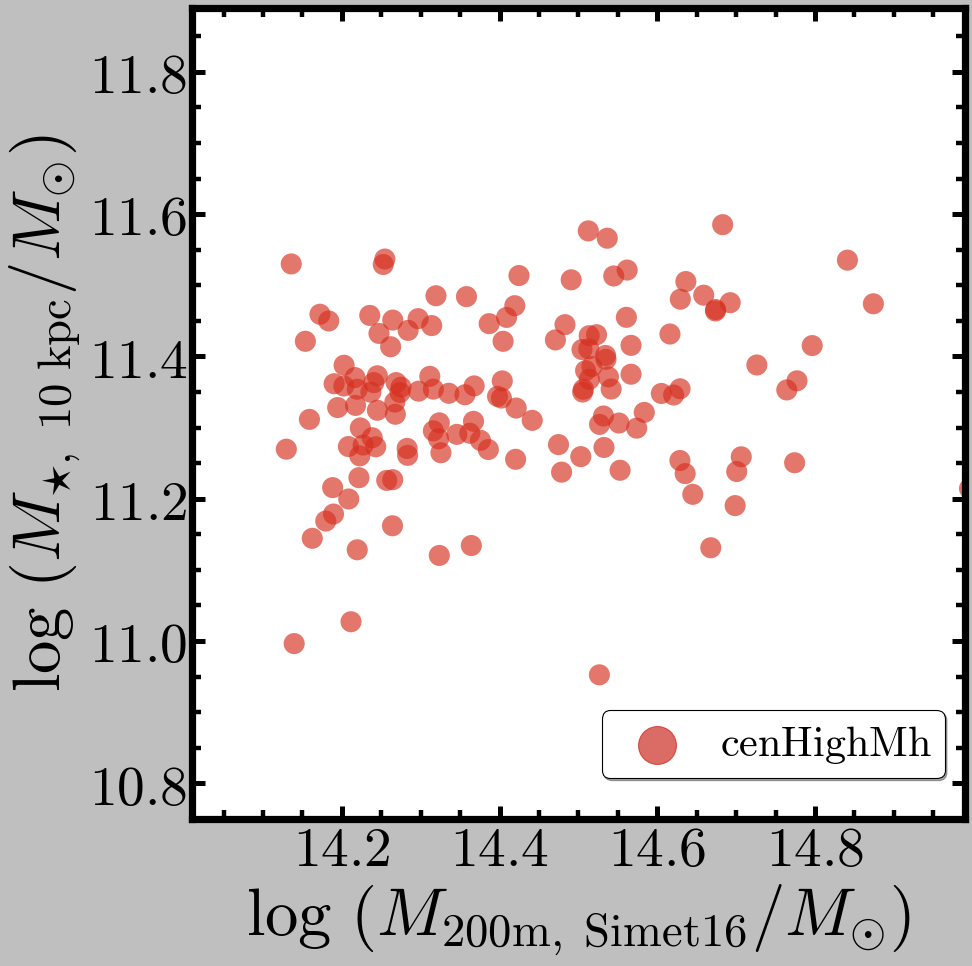

In [19]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(mhalo1, redbcgCleanU['logm_10'],
            marker='o', edgecolor='none', cmap=ORG, s=360,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200m,\ Simet16}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{10\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(10.75, 11.89)
ax1.set_xlim(14.01, 14.99)

# Overplot Mass-Size relation from Huertas-Company+13: 
#ax1.plot(logmC_hc13 - 0.05 + 0.10, logrC_hc13, linestyle='--', linewidth=8.0, alpha=0.8,
#         c=GRN(0.9), label='$\mathrm{HC2013; Cen}; z<0.09$', dashes=(25,8), zorder=100)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(ORG(0.8))

#ax1.axvline(14.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
#ax1.axvline(14.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logm200m_logm10_1.pdf'), dpi=150)

plt.show()

In [20]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.20, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(mhalo1, redbcgCleanU['MSTAR'],
            marker='o', edgecolor='none', cmap=ORG, s=360,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200m,\ Simet16}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{cModel}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 12.19)
ax1.set_xlim(14.01, 14.99)

# Overplot Mass-Size relation from Huertas-Company+13: 
#ax1.plot(logmC_hc13 - 0.05 + 0.10, logrC_hc13, linestyle='--', linewidth=8.0, alpha=0.8,
#         c=GRN(0.9), label='$\mathrm{HC2013; Cen}; z<0.09$', dashes=(25,8), zorder=100)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(ORG(0.8))

#ax1.axvline(14.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
#ax1.axvline(14.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logm200m_logmCmodel_1.pdf'), dpi=150)

plt.show()

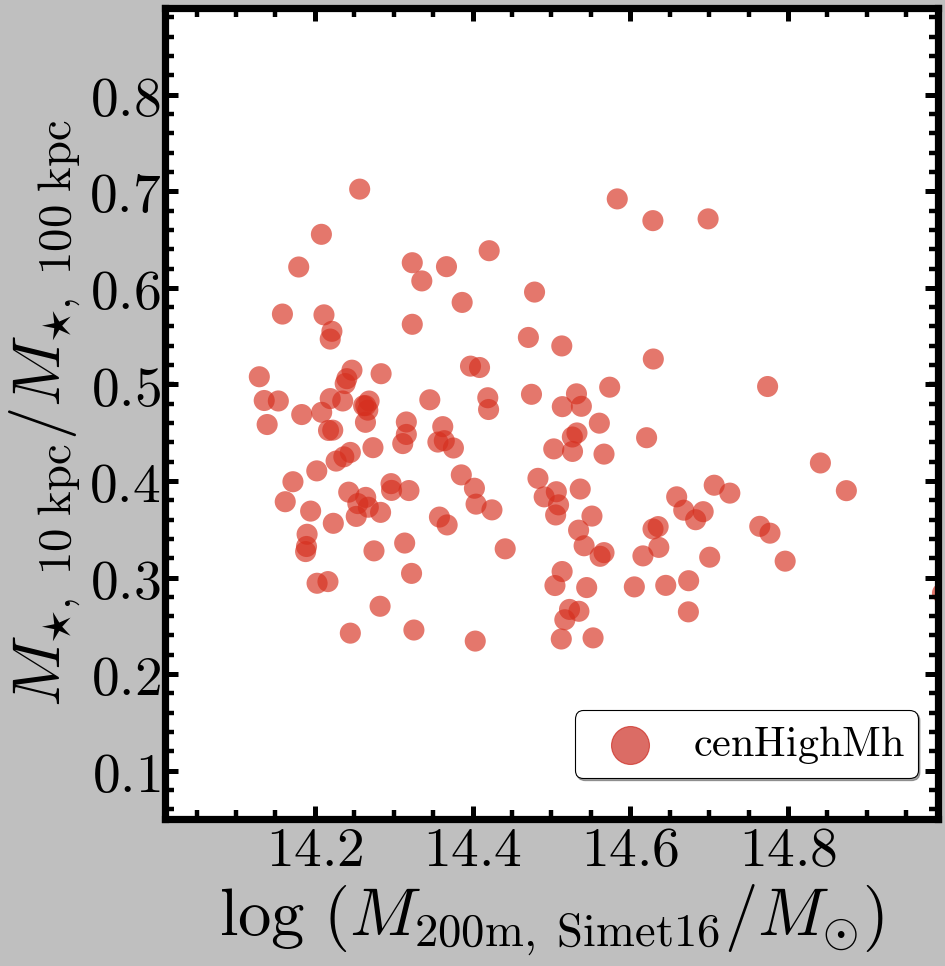

In [21]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(mhalo1, 10.0 ** (redbcgCleanU['logm_10'] - redbcgCleanU['logm_100']) ,
            marker='o', edgecolor='none', cmap=ORG, s=360,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200m,\ Simet16}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('${M_{\star,\ \mathrm{10\ kpc}}}/M_{\star,\ \mathrm{100\ kpc}}$', 
               size=60)

# X, Y limits
ax1.set_ylim(0.05, 0.89)
ax1.set_xlim(14.01, 14.99)

# Overplot Mass-Size relation from Huertas-Company+13: 
#ax1.plot(logmC_hc13 - 0.05 + 0.10, logrC_hc13, linestyle='--', linewidth=8.0, alpha=0.8,
#         c=GRN(0.9), label='$\mathrm{HC2013; Cen}; z<0.09$', dashes=(25,8), zorder=100)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()
legend.legendHandles[0].set_color(ORG(0.8))

#ax1.axvline(14.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
#ax1.axvline(14.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logm200m_logm100-10_1.pdf'), dpi=150)

plt.show()

# Relation between total stellar mass and fraction of accreted stars

In [12]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonbcgCleanU['logm_100'], 
            1.0 - 10.0 ** (nonbcgCleanU['logm_10'] - nonbcgCleanU['logm_100']) ,
            marker='o', edgecolor='none', cmap=BLK, s=80,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redbcgCleanU['logm_100'], 
            1.0 - 10.0 ** (redbcgCleanU['logm_10'] - redbcgCleanU['logm_100']) ,
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\star, \mathrm{100,\ kpc}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('${M_{\star,\ \mathrm{10\ kpc}}}/M_{\star,\ \mathrm{100\ kpc}}$', 
               size=60)

# X, Y limits
ax1.set_ylim(0.05, 0.84)
ax1.set_xlim(10.91, 12.09)

# Overplot Mass-Size relation from Huertas-Company+13: 
ax1.plot(np.log10(accFrac1['mass']), accFrac1['frac'], 
         linestyle='-', linewidth=8.0, alpha=0.8,
         c=BLK(0.9), label='$\mathrm{Illustris}$', zorder=0)
ax1.plot(np.log10(accFrac2['mass']), accFrac2['frac'], 
         linestyle='--', linewidth=8.0, alpha=0.8,
         c=BLK(0.9), dashes=(25,8), zorder=0, label='_nolegend_')
ax1.plot(np.log10(accFrac3['mass']), accFrac3['frac'], 
         linestyle='--', linewidth=8.0, alpha=0.8,
         c=BLK(0.9), dashes=(25,8), zorder=0, label='_nolegend_')

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(14.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(14.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logm100_logm100-10_1.pdf'), dpi=150)

plt.show()

In [38]:
logm10 = np.asarray(nonbcgCleanU['logm_10'].data)
logm100 = np.asarray(nonbcgCleanU['logm_100'].data)

logm10Err = np.sqrt(np.asarray(nonbcgCleanU['MSTAR_ERR'].data) ** 2.0 + 0.002** 2.0)
logm100Err = np.sqrt(np.asarray(nonbcgCleanU['MSTAR_ERR'].data) ** 2.0 + 0.005 ** 2.0)

m10 = 10.0 ** logm10
m100 = 10.0 ** logm100
m10Err = np.abs(10.0 ** (logm10 - logm10Err) - 10.0 ** logm10)
m100Err = np.abs(10.0 ** (logm100 - logm100Err) - 10.0 ** logm100)

import uncertainties as unc  
import uncertainties.unumpy as unumpy
from uncertainties.umath import *

x = unumpy.uarray((m10, m10Err))  
y = unumpy.uarray((m100, m100Err)) 

mRatio = (y - x) / y
   
# Print the propagated error errz  
mRatioErr = unumpy.std_devs(z)  

print(np.nanmedian(logm10Err), np.nanmedian(logm100Err), np.nanmedian(mRatioErr))

0.0487572 0.0489721 0.0991234692654


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.


In [46]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonbcgCleanU['logm_100'], 
            1.0 - 10.0 ** (nonbcgCleanU['logm_10'] - nonbcgCleanU['logm_100']) ,
            marker='o', edgecolor=ORG(0.95), cmap=BLK, s=100,
            c=ORG(0.7), 
            alpha=0.45, label='$\mathrm{HSC}$',
            rasterized=True)
ax1.scatter(redbcgCleanU['logm_100'], 
            1.0 - 10.0 ** (redbcgCleanU['logm_10'] - redbcgCleanU['logm_100']) ,
            marker='o', edgecolor=ORG(0.95), cmap=ORG, s=100,
            c=ORG(0.7), 
            alpha=0.45, label='_nolegend_', 
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\star, \mathrm{100,\ kpc}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\mathrm{Fraction\ of\ }\Delta\ (M_{100-10\ \mathrm{kpc}})$', 
               size=60)

# X, Y limits
ax1.set_ylim(0.05, 0.94)
ax1.set_xlim(10.91, 12.09)

# Overplot Mass-Size relation from Huertas-Company+13: 
ax1.plot(np.log10(accFrac1['mass']), accFrac1['frac'], 
         linestyle='-', linewidth=8.0, alpha=0.6,
         c=BLK(0.9), label='$\mathrm{Illustris}$', zorder=2)
ax1.plot(np.log10(accFrac2['mass']), accFrac2['frac'], 
         linestyle='--', linewidth=8.0, alpha=0.6,
         c=BLK(0.9), dashes=(25,8), zorder=0, label='_nolegend_')
ax1.plot(np.log10(accFrac3['mass']), accFrac3['frac'], 
         linestyle='--', linewidth=8.0, alpha=0.6,
         c=BLK(0.9), dashes=(25,8), zorder=0, label='_nolegend_')

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(14.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(14.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

# Typical error bar 
ax1.errorbar(11.05, 0.80, xerr=0.04, yerr=0.09, ecolor=ORG(0.8), elinewidth=3, 
             capsize=15, capthick=3)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logm100_logm100-10_2.pdf'), dpi=150)

plt.show()

# Estimate R200c using Colossus

## Setup the cosmology

In [8]:
from colossus.cosmology import cosmology

myCos = {'flat': True, 'H0': 70.0, 'Om0': 0.30, 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
cosmo = cosmology.setCosmology('my_cosmo', myCos)

In [11]:
from colossus.halo import mass_so, mass_defs
from colossus.halo import concentration, profile_nfw

rho_m = mass_so.densityThreshold(redbcgCleanU['z_use'], '200m')
r200m = mass_so.M_to_R((10.0 ** mhalo1), redbcgCleanU['z_use'], '200m')

# Assign halo mass using Behroozi 2010 relation

In [9]:
def behrooziMh2010(Ms, logMl=12.35, logMs0=10.72, 
                   beta=0.44, delta=0.57, gamma=1.56, 
                   logMl_a=0.55, logMs0_a=0.28, 
                   beta_a=0.18, delta_a=0.17, gamma_a=2.51,
                   redshift=None):
    
    Ml = 10.0 ** logMl
    Ms0 = 10.0 ** logMs0
    
    if redshift is not None and len(redshift) == len(Ms):
        scaleFactor = 1.0 / (1.0 + redshift) - 1.0
        logMl = logMl + logMl_a * scaleFactor
        logMs0 = logMs0 + logMs0_a * scaleFactor
        beta = beta + beta_a * scaleFactor
        delta = delta + delta_a * scaleFactor
        gamma = gamma + gamma_a * scaleFactor
    
    term1 = np.log10(Ml) + beta * np.log10(Ms / Ms0)
    term2 = (Ms / Ms0) ** delta
    term3 = 1.0 + (Ms / Ms0) ** (-1.0 * gamma)
    
    return (term1 + (term2 / term3) - 0.5)

## Using Leauthaud+2012

In [48]:
smhm1 = hscSMHM.Leauthaud12(redshift=0.4)
smhm2 = hscSMHM.Leauthaud12(redshift=0.7)
smhm3 = hscSMHM.Leauthaud12(redshift=0.9)

redMhaloA = smhm1.toMhalo(10.0 ** redbcgCleanU['logm_100'])
redMhaloB = smhm1.toMhalo(10.0 ** redbcgCleanU['MSTAR'])
redMhaloC = smhm1.toMhalo(10.0 ** redbcgCleanU['logm_10'])
redMhaloD = smhm1.toMhalo(10.0 ** redbcgCleanU['logm_30'])
redMhaloE = smhm1.toMhalo(10.0 ** redbcgCleanU['logm_50'])

redMhaloA0 = smhm3.toMhalo(10.0 ** redbcgCleanU['logm_100'])
redMhaloB0 = smhm3.toMhalo(10.0 ** redbcgCleanU['MSTAR'])
redMhaloC0 = smhm3.toMhalo(10.0 ** redbcgCleanU['logm_10'])
redMhaloD0 = smhm3.toMhalo(10.0 ** redbcgCleanU['logm_30'])
redMhaloE0 = smhm3.toMhalo(10.0 ** redbcgCleanU['logm_50'])

nonMhaloA = smhm1.toMhalo(10.0 ** nonbcgCleanU['logm_100'])
nonMhaloB = smhm1.toMhalo(10.0 ** nonbcgCleanU['MSTAR'])
nonMhaloC = smhm1.toMhalo(10.0 ** nonbcgCleanU['logm_10'])
nonMhaloD = smhm1.toMhalo(10.0 ** nonbcgCleanU['logm_30'])
nonMhaloE = smhm1.toMhalo(10.0 ** nonbcgCleanU['logm_50'])

nonMhaloA0 = smhm3.toMhalo(10.0 ** nonbcgCleanU['logm_100'])
nonMhaloB0 = smhm3.toMhalo(10.0 ** nonbcgCleanU['MSTAR'])
nonMhaloC0 = smhm3.toMhalo(10.0 ** nonbcgCleanU['logm_10'])
nonMhaloD0 = smhm3.toMhalo(10.0 ** nonbcgCleanU['logm_30'])
nonMhaloE0 = smhm3.toMhalo(10.0 ** nonbcgCleanU['logm_50'])

In [73]:
redC = redbcgCleanU.copy()
redC['sample'] = Column(data=np.full(len(redbcgCleanU), 1, dtype=int), 
                        description="sample")
nonC = nonbcgCleanU.copy()
nonC['sample'] = Column(data=np.full(len(nonbcgCleanU), 0, dtype=int), 
                        description="sample")
redU = redC['MSTAR', 'MSTAR_ERR', 'logm_100', 'logm_10', 'logm_5', 'logm_30', 
            'logm_50', 'logm_max', 'sample']
nonU = nonC['MSTAR', 'MSTAR_ERR', 'logm_100', 'logm_10', 'logm_5', 'logm_30', 
            'logm_50', 'logm_max', 'sample']

hscU = vstack([redU, nonU], metadata_conflicts='silent')

hscU['logmh_A'] = Column(data=smhm1.toMhalo(10.0 ** hscU['logm_100']),
                         description='halo mass m100')

msArr = np.linspace(10.0, 13.0, 100)
mhArr = smhm1.bootstrapMhalo(10.0 ** msArr, n=30000)

mhAMed = np.percentile(mhArr, 50, axis=0)
mhALow = np.percentile(mhArr, 32, axis=0)
mhAUpp = np.percentile(mhArr, 68, axis=0)

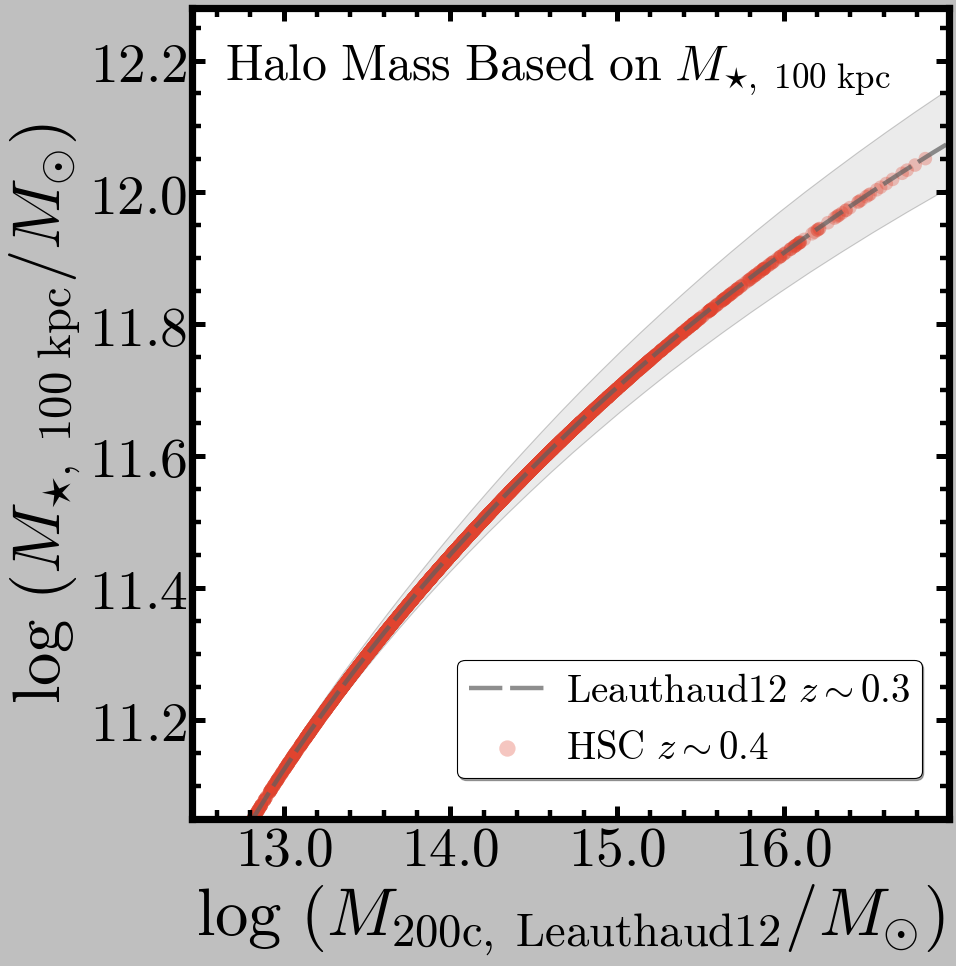

In [75]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

"""
# z=0.9
ax1.scatter(nonMhA0, nonbcgCleanU['logm_100'],
            marker='o', facecolor='none', cmap=ORG, s=70,
            edgecolor=BLK(0.45), 
            alpha=0.45, label='$\mathrm{cenLowMh,\ }z=0.8$',
            rasterized=True)
ax1.scatter(redMhA0, redbcgCleanU['logm_100'],
            marker='s', facecolor='none', cmap=ORG, s=380,
            edgecolor=ORG(0.75), 
            alpha=0.85, label='$\mathrm{cenHighMh,\ }z=0.8$',
            rasterized=True)
"""

# z=0.3
ax1.fill_betweenx(msArr, mhALow, mhAUpp, facecolor=BLK(0.3), edgecolor=BLK(0.6), 
                  alpha=0.4, zorder=0, rasterized=True)

ax1.plot(mhAMed, msArr, linestyle='--', linewidth=4, c=BLK(0.7), alpha=0.7,
         dashes=(30, 7), rasterized=True, label='$\mathrm{Leauthaud12}\ z{\sim}0.3$')

ax1.scatter(hscU['logmh_A'], hscU['logm_100'],
            marker='o', edgecolor='none', cmap=ORG, s=150,
            c=ORG(0.7), 
            alpha=0.3, label='$\mathrm{HSC}\ z{\sim}0.4$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{100\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.05, 12.28)
ax1.set_xlim(12.45, 16.99)


ax1.text(12.65, 12.17, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{100\ kpc}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.35, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=35, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

#ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
#ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_m100_logm100_leauthaud12.pdf'), dpi=90)

plt.show()

In [143]:
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit

def smhmL12(params, logms, data):
    """SMHM relation from Leauthaud+12"""
    m0 = params['logms0']
    m1 = params['logm1']
    dd = params['delta']
    bb = params['beta']
    gg = params['gamma']
    
    mRatio = (10.0 ** logms) / (10.0 ** m0)
    
    termB = np.log10(mRatio) * bb
    termC = mRatio ** dd
    termD = mRatio ** (gg * -1.0) + 1.0

    model = m1 + termB + (termC / termD) - 0.50
    
    return model - data

def smhmLinear(params, logmh, data):
    """Simple log-log linear relation."""
    aa = params['a']
    bb = params['b']
    
    model = aa * logmh + bb

    return model - data
    
# cModel v.s Mhalo
params = Parameters()
#params.add('logms0', value=10.92, min=9.0, max=12.5)
#params.add('logm1', value=12.52, min=10.50, max=15.0)
#params.add('delta', value=0.566, min=0.1, max=1.0)
#params.add('beta', value=0.457, min=0.1, max=1.0)
#params.add('gamma', value=1.530, min=0.4, max=10.0)
params.add('a', value=0.8, min=0.0, max=2.0)
params.add('b', value=0.0, min=-100, max=100)

# do fit, here with leastsq model
hscA = hscU.copy()
hscA = hscA[(hscA['logmh_A'] >= 13.5) & (hscA['logmh_A'] < 15.0)]
hscA.sort('logmh_A')
logmh = np.asarray(hscA['logmh_A'])
data = np.asarray(hscA['MSTAR'])

minner = Minimizer(smhmLinear, params, fcn_args=(logmh, data))
result = minner.minimize(method='differential_evolution')
pCmod_1 = result.params

report_fit(result)

mCmod_1 = pCmod_1['a'] * hscU['logmh_A'] + pCmod_1['b']

[[Fit Statistics]]
    # function evals   = 793
    # data points      = 3141
    # variables        = 2
    chi-square         = 18.499
    reduced chi-square = 0.006
    Akaike info crit   = -16123.777
    Bayesian info crit = -16111.673
[[Variables]]
    a:   0.23767616 (init= 0.8)
    b:   8.06216376 (init= 0)


In [145]:
# m10 v.s Mhalo
params = Parameters()
#params.add('logms0', value=10.92, min=8.0, max=12.0)
#params.add('logm1', value=12.52, min=10.50, max=15.0)
#params.add('delta', value=0.566, min=0.1, max=1.0)
#params.add('beta', value=0.457, min=0.1, max=1.0)
#params.add('gamma', value=1.530, min=0.2, max=10.0)
params.add('a', value=0.8, min=0.0, max=2.0)
params.add('b', value=0.0, min=-100, max=100)

# do fit, here with leastsq model
hscB = hscU.copy()
hscB = hscB[(hscB['logmh_A'] >= 13.5) & (hscB['logmh_A'] < 15.0)]
hscB.sort('logmh_A')
logmh = np.asarray(hscB['logmh_A'])
data = np.asarray(hscB['logm_10'])

minner = Minimizer(smhmLinear, params, fcn_args=(logmh, data))
result = minner.minimize(method='differential_evolution')
pM10_1 = result.params

report_fit(result)

mM10_1 = pM10_1['a'] * hscU['logmh_A'] + pM10_1['b']

[[Fit Statistics]]
    # function evals   = 994
    # data points      = 3141
    # variables        = 2
    chi-square         = 9.549
    reduced chi-square = 0.003
    Akaike info crit   = -18200.679
    Bayesian info crit = -18188.574
[[Variables]]
    a:   0.18645539 (init= 0.8)
    b:   8.59752896 (init= 0)


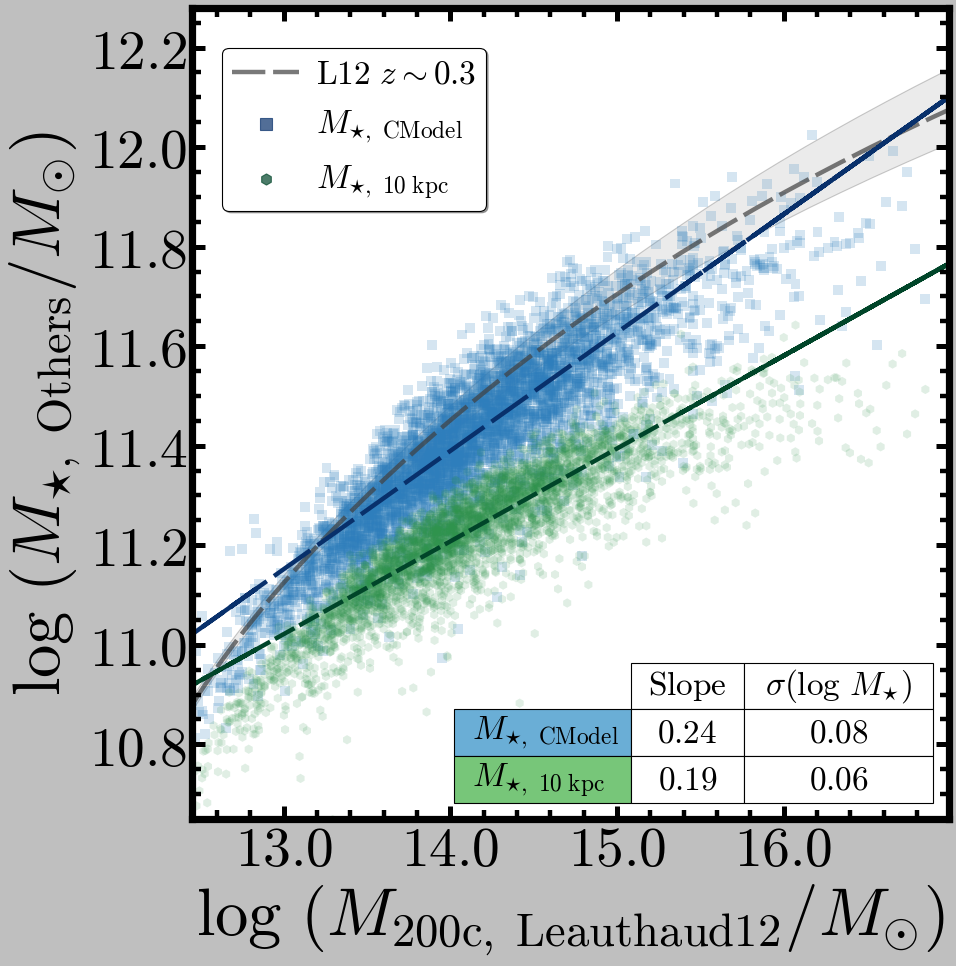

In [155]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

"""
# z=0.9
ax1.scatter(nonMhA0, nonbcgCleanU['logm_100'],
            marker='o', facecolor='none', cmap=ORG, s=70,
            edgecolor=BLK(0.45), 
            alpha=0.45, label='$\mathrm{cenLowMh,\ }z=0.8$',
            rasterized=True)
ax1.scatter(redMhA0, redbcgCleanU['logm_100'],
            marker='s', facecolor='none', cmap=ORG, s=380,
            edgecolor=ORG(0.75), 
            alpha=0.85, label='$\mathrm{cenHighMh,\ }z=0.8$',
            rasterized=True)
"""

# z=0.3
ax1.fill_betweenx(msArr, mhALow, mhAUpp, facecolor=BLK(0.3), edgecolor=BLK(0.6), 
                  alpha=0.4, zorder=0, rasterized=True)

ax1.plot(mhAMed, msArr, linestyle='--', linewidth=4, c=BLK(0.8), alpha=0.7,
         dashes=(30, 7), rasterized=True, label='$\mathrm{L12}\ z{\sim}0.3$')

ax1.scatter(hscU['logmh_A'], hscU['MSTAR'],
            marker='s', edgecolor='none', s=80,
            c=BLU(0.7), 
            alpha=0.2, label='$M_{\star,\ \mathrm{CModel}}$',
            rasterized=True)
ax1.plot(hscU['logmh_A'], mCmod_1, linestyle='--', linewidth=4, c=BLU(1.0), 
         dashes=(40,8), rasterized=True, label='__no_label')

ax1.scatter(hscU['logmh_A'], hscU['logm_10'],
            marker='h', edgecolor='none', cmap=ORG, s=70,
            c=GRN(0.7), 
            alpha=0.15, label='$M_{\star,\ \mathrm{10\ kpc}}$',
            rasterized=True)
ax1.plot(hscU['logmh_A'], mM10_1, linestyle='--', linewidth=4, c=GRN(1.0), 
         dashes=(20,5), rasterized=True, label='__no_label')

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{Others}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(10.65, 12.28)
ax1.set_xlim(12.45, 16.99)


#ax1.text(12.61, 12.17, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{100,\ kpc}}$', 
#         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.04, 0.75),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=30, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()
legend.legendHandles[1].set_color(BLU(1.0))
legend.legendHandles[2].set_color(GRN(1.0))
legend.legendHandles[1].set_alpha(0.7)
legend.legendHandles[2].set_alpha(0.7)

# --------------------------------------------------------------------------------------- #
col_labels = [r'$\mathrm{Slope}$', r'$\sigma(\log\ M_{\star})$']
row_labels = [r'$M_{\star,\ \mathrm{CModel}}$', 
              r'$M_{\star,\ \mathrm{10 \ kpc}}$']
table_vals = [['$0.24$', '$0.08$'], ['$0.19$', '$0.06$']]

the_table = ax1.table(cellText=table_vals,
                      colWidths=[0.06, 0.10],
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      cellLoc='center',
                      rowColours=[BLU(0.5), GRN(0.5)],
                      loc='lower right')
the_table.auto_set_font_size(False)
the_table.set_fontsize(30)
the_table.scale(2.5, 3.5)
# --------------------------------------------------------------------------------------- #

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_mElse1_logm100_leauthaud12.pdf'), dpi=90)

plt.show()

In [149]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')


# z=0.3
#ax1.fill_betweenx(msArr, mhAMed - mhALow, mhAUpp - mhAMed, facecolor=BLK(0.3), edgecolor=BLK(0.6), 
#                  alpha=0.4, zorder=0, rasterized=True)

ax1.axhline(0.0, linestyle='--', linewidth=4, c=BLK(0.8), alpha=0.7,
            dashes=(30, 7), rasterized=True, label='$\mathrm{L12}\ z{\sim}0.3$')

sigCmod_1 = hscU['MSTAR'] - mCmod_1
ax1.scatter(hscU['logmh_A'], sigCmod_1,
            marker='s', edgecolor='none', s=80,
            c=BLU(0.7), 
            alpha=0.2, label='$M_{\star,\ \mathrm{CModel}}$',
            rasterized=True)

stdCmod_1 = np.nanstd(sigCmod_1[(hscU['logmh_A'] >= 13.2) & (hscU['logmh_A'] < 15.2)])


#ax1.plot(mCmod_1, hscU['MSTAR'], linestyle='--', linewidth=4, c=BLU(1.0), 
#         dashes=(40,8), rasterized=True, label='__no_label')

sigM10_1 = hscU['logm_10'] - mM10_1
ax1.scatter(hscU['logmh_A'], sigM10_1,
            marker='h', edgecolor='none', cmap=ORG, s=70,
            c=GRN(0.7), 
            alpha=0.15, label='$M_{\star,\ \mathrm{10\ kpc}}$',
            rasterized=True)

stdM10_1 = np.nanstd(sigM10_1[(hscU['logmh_A'] >= 13.2) & (hscU['logmh_A'] < 15.2)])

print(stdCmod_1, stdM10_1)

#ax1.plot(mM10_1, hscU['logm_10'], linestyle='--', linewidth=4, c=GRN(1.0), 
#         dashes=(20,5), rasterized=True, label='__no_label')

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{Others}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(-0.39, 0.39)
ax1.set_xlim(12.45, 16.99)


# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.04, 0.75),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=30, scatterpoints=1, 
           markerscale=1.2, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()
legend.legendHandles[1].set_color(BLU(1.0))
legend.legendHandles[2].set_color(GRN(1.0))
legend.legendHandles[1].set_alpha(0.7)
legend.legendHandles[2].set_alpha(0.7)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_dlogm_logm100_leauthaud12.pdf'), dpi=90)

plt.show()

0.0763548270276 0.0558828720126


In [55]:
xx, yy = redMhaloA, redbcgCleanU['MSTAR']
xx = xx[redMhaloA > 13.9]
yy = yy[redMhaloA > 13.9]
yyErr = yy * 0.0 + 0.02

A = np.vstack((np.ones_like(xx), xx)).T
C = np.diag(yyErr * yyErr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
redB1, redA1 = np.dot(cov, np.dot(A.T, np.linalg.solve(C, yy)))

xx, yy = nonMhaloA, nonbcgCleanU['MSTAR']
xx = xx[nonMhaloA > 13.9]
yy = yy[nonMhaloA > 13.9]
yyErr = yy * 0.0 + 0.02

A = np.vstack((np.ones_like(xx), xx)).T
C = np.diag(yyErr * yyErr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
nonB1, nonA1 = np.dot(cov, np.dot(A.T, np.linalg.solve(C, yy)))

In [56]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

# z=0.3
xx = np.linspace(12.0, 17.0, 100)
ax1.plot(xx, (redA1 * xx + redB1), linestyle='--', c=ORG(0.9), 
         linewidth=5, dashes=(40, 10))
ax1.plot(xx, (nonA1 * xx + nonB1), linestyle='--', c=BLK(0.8), 
         linewidth=5, dashes=(20, 5))

ax1.scatter(nonMhaloA, nonbcgCleanU['MSTAR'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}\ z=0.3$',
            rasterized=True)
ax1.scatter(redMhaloA, redbcgCleanU['MSTAR'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}\ z=0.3$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{cModel}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.05, 12.28)
ax1.set_xlim(12.05, 16.99)


ax1.text(12.31, 12.12, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{100,\ kpc}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.48, 0.03),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=29, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axhline(11.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axhline(11.90, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_mcmodel_logm100_leauthaud12.pdf'), dpi=90)

plt.show()

0.0804880666799
0.0803135589591


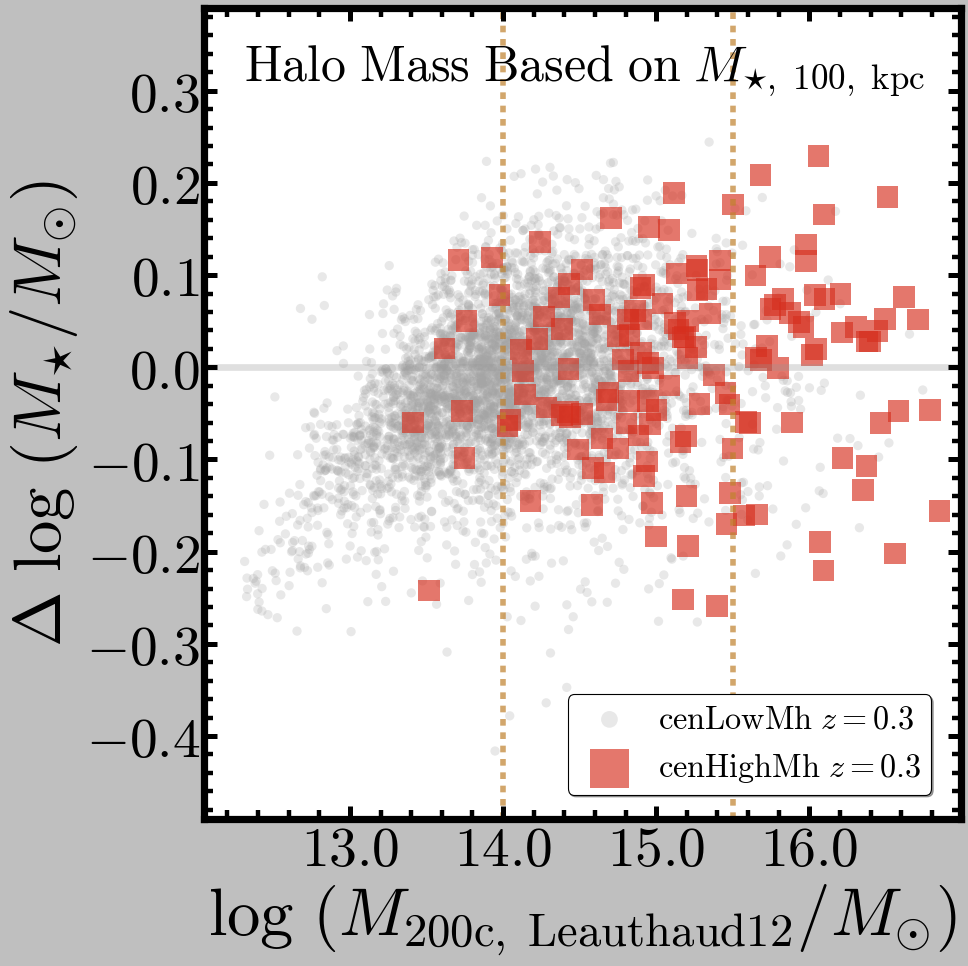

In [70]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

# z=0.3
xx = nonMhaloA
yy = nonbcgCleanU['MSTAR'] - (nonA1 * xx + nonB1)
ax1.scatter(xx, yy,
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}\ z=0.3$',
            rasterized=True)
print(np.nanstd(yy[(xx >= 14.0) & (xx < 15.0)]))

xx = redMhaloA
yy = redbcgCleanU['MSTAR'] - (redA1 * xx + redB1)
ax1.scatter(xx, yy,
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}\ z=0.3$',
            rasterized=True)
print(np.nanstd(yy[(xx >= 14.0) & (xx < 15.0)]))


# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\Delta\ \log\ ({M_{\star}}/M_{\odot})$', size=60)

# X, Y limits
ax1.set_xlim(12.05, 16.99)
ax1.set_ylim(-0.49, 0.39)

ax1.text(12.31, 0.31, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{100,\ kpc}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.48, 0.03),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=29, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axhline(0.0, linestyle='-', linewidth=6.0, alpha=0.3, c=BLK(0.5))
ax1.axvline(14.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_sigDm_leauthaud12_1.pdf'), dpi=90)

plt.show()

In [44]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

# z=0.9
ax1.scatter(nonMhaloB0, nonbcgCleanU['MSTAR'],
            marker='o', facecolor='none', cmap=ORG, s=70,
            edgecolor=BLK(0.45), 
            alpha=0.45, label='$\mathrm{cenLowMh,\ }z=0.8$',
            rasterized=True)
ax1.scatter(redMhaloB0, redbcgCleanU['MSTAR'],
            marker='s', facecolor='none', cmap=ORG, s=380,
            edgecolor=ORG(0.75), 
            alpha=0.85, label='$\mathrm{cenHighMh,\ }z=0.8$',
            rasterized=True)
# z=0.3
ax1.scatter(nonMhaloB, nonbcgCleanU['MSTAR'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}\ z=0.3$',
            rasterized=True)
ax1.scatter(redMhaloB, redbcgCleanU['MSTAR'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}\ z=0.3$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{cModel}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.05, 12.28)
ax1.set_xlim(12.05, 16.99)


ax1.text(12.31, 12.12, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{cModel}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.48, 0.03),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=29, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

#ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
#ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_mcmodel_logmcmodel_leauthaud12.pdf'), dpi=90)

plt.show()

In [57]:
xx, yy = redMhaloB, redbcgCleanU['logm_100']
xx = xx[redMhaloB > 13.9]
yy = yy[redMhaloB > 13.9]
yyErr = yy * 0.0 + 0.02

A = np.vstack((np.ones_like(xx), xx)).T
C = np.diag(yyErr * yyErr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
redB2, redA2 = np.dot(cov, np.dot(A.T, np.linalg.solve(C, yy)))

xx, yy = nonMhaloB, nonbcgCleanU['logm_100']
xx = xx[nonMhaloB > 13.9]
yy = yy[nonMhaloB > 13.9]
yyErr = yy * 0.0 + 0.025

A = np.vstack((np.ones_like(xx), xx)).T
C = np.diag(yyErr * yyErr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
nonB2, nonA2 = np.dot(cov, np.dot(A.T, np.linalg.solve(C, yy)))

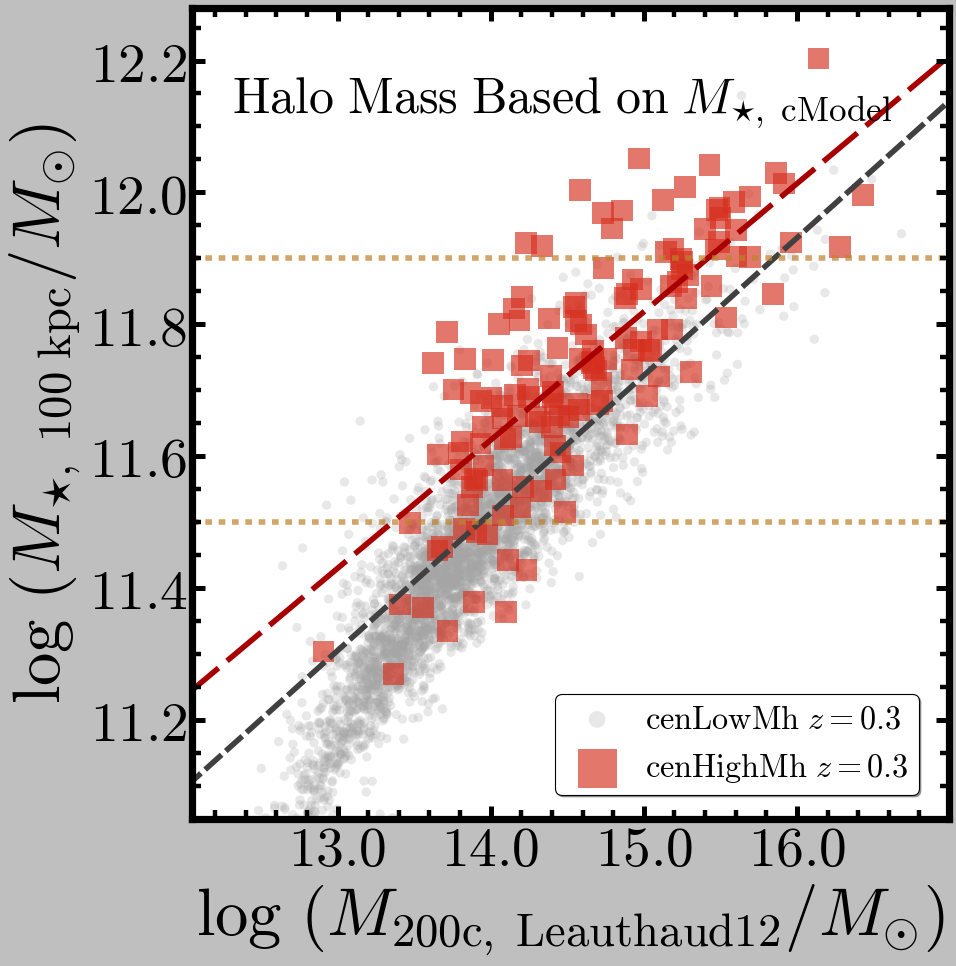

In [58]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

# z=0.3
xx = np.linspace(12.0, 17.0, 100)
ax1.plot(xx, (redA2 * xx + redB2), linestyle='--', c=ORG(0.9), 
         linewidth=5, dashes=(40, 10))
ax1.plot(xx, (nonA2 * xx + nonB2), linestyle='--', c=BLK(0.8), 
         linewidth=5, dashes=(20, 5))

ax1.scatter(nonMhaloB, nonbcgCleanU['logm_100'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}\ z=0.3$',
            rasterized=True)
ax1.scatter(redMhaloB, redbcgCleanU['logm_100'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}\ z=0.3$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{100\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.05, 12.28)
ax1.set_xlim(12.05, 16.99)


ax1.text(12.31, 12.12, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{cModel}}$', 
         size=45)

ax1.axhline(11.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axhline(11.90, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.48, 0.03),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=29, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()


#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_m100_logmcmodel_leauthaud12.pdf'), dpi=90)

plt.show()

0.0746171322802
0.115418521983


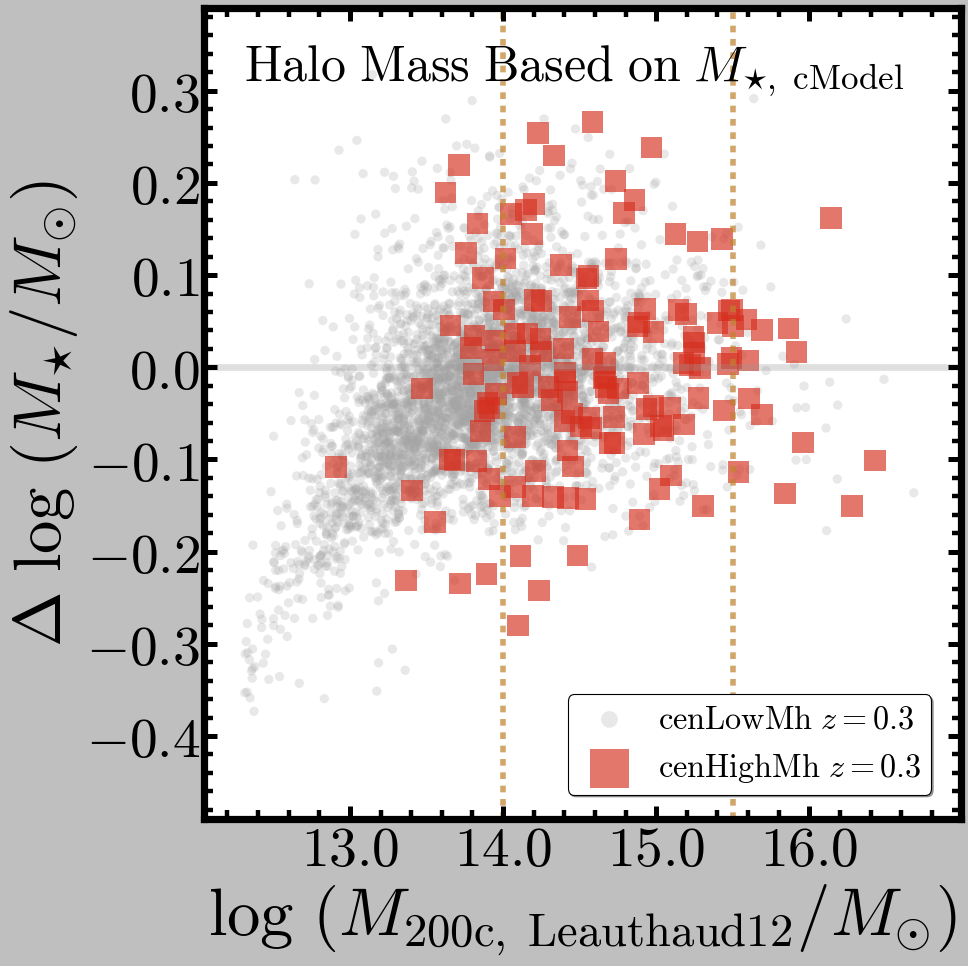

In [69]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

# z=0.3
xx = nonMhaloB
yy = nonbcgCleanU['logm_100'] - (nonA2 * xx + nonB2)
ax1.scatter(xx, yy,
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}\ z=0.3$',
            rasterized=True)
print(np.nanstd(yy[(xx >= 14.0) & (xx < 15.0)]))

xx = redMhaloB
yy = redbcgCleanU['logm_100'] - (redA2 * xx + redB2)
ax1.scatter(xx, yy,
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}\ z=0.3$',
            rasterized=True)
print(np.nanstd(yy[(xx >= 14.0) & (xx < 15.0)]))


# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Leauthaud12}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\Delta\ \log\ ({M_{\star}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_xlim(12.05, 16.99)
ax1.set_ylim(-0.49, 0.39)

ax1.text(12.31, 0.31, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{cModel}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.48, 0.03),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=29, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axhline(0.0, linestyle='-', linewidth=6.0, alpha=0.3, c=BLK(0.5))
ax1.axvline(14.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.50, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_sigDm_leauthaud12_2.pdf'), dpi=90)

plt.show()

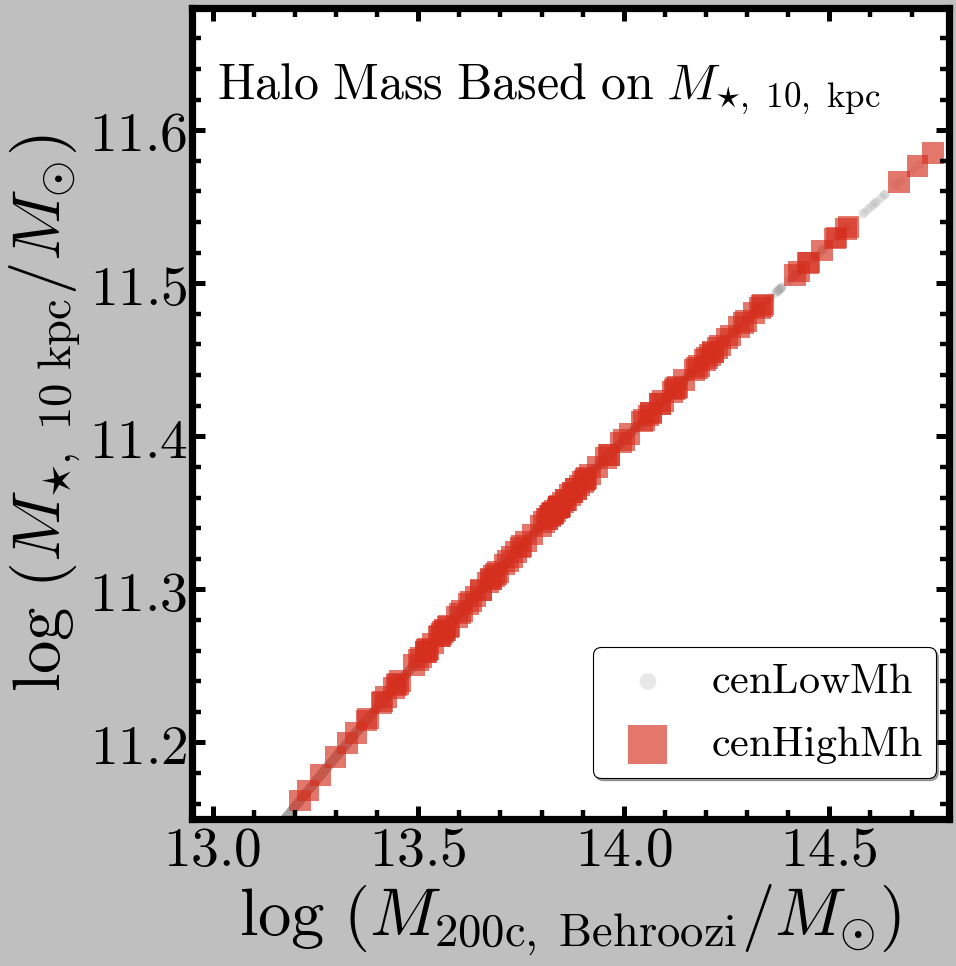

In [21]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonMhaloC0, nonbcgCleanU['logm_10'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redMhaloC0, redbcgCleanU['logm_10'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Behroozi}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{10\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 11.68)
ax1.set_xlim(12.95, 14.79)


ax1.text(13.01, 11.62, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{10,\ kpc}}$', 
         size=45)


# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_m10_logm10_1.pdf'), dpi=100)

plt.show()

In [24]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.21, right=0.998, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonMhaloC0, nonbcgCleanU['logm_100'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redMhaloC0, redbcgCleanU['logm_100'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Behroozi}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{100\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 12.19)
ax1.set_xlim(12.95, 14.79)


ax1.text(13.01, 12.09, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{10,\ kpc}}$', 
         size=45)


# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_m10_logm100_1.pdf'), dpi=100)

plt.show()

## Using Behroozi+2010

In [12]:
redMhaloB = behrooziMh2010(10.0 ** (redbcgCleanU['logm_100'] - 0.1), 
                           redshift=redbcgCleanU['z_use'])
redMhaloB0 = behrooziMh2010(10.0 ** (redbcgCleanU['logm_100'] - 0.1), 
                            redshift=None) 
redMhaloA = behrooziMh2010(10.0 ** (redbcgCleanU['MSTAR'] - 0.1), 
                           redshift=redbcgCleanU['z_use'])
redMhaloA0 = behrooziMh2010(10.0 ** (redbcgCleanU['MSTAR'] - 0.1), 
                            redshift=None) 
redMhaloC = behrooziMh2010(10.0 ** (redbcgCleanU['logm_10'] - 0.1), 
                           redshift=redbcgCleanU['z_use'])
redMhaloC0 = behrooziMh2010(10.0 ** (redbcgCleanU['logm_10'] - 0.1), 
                            redshift=None) 

nonMhaloB = behrooziMh2010(10.0 ** (nonbcgCleanU['logm_100'] - 0.1), 
                           redshift=nonbcgCleanU['z_use'])
nonMhaloB0 = behrooziMh2010(10.0 ** (nonbcgCleanU['logm_100'] - 0.1), 
                            redshift=None) 
nonMhaloA = behrooziMh2010(10.0 ** (nonbcgCleanU['MSTAR'] - 0.1), 
                           redshift=nonbcgCleanU['z_use'])
nonMhaloA0 = behrooziMh2010(10.0 ** (nonbcgCleanU['MSTAR'] - 0.1), 
                            redshift=None) 
nonMhaloC = behrooziMh2010(10.0 ** (nonbcgCleanU['logm_10'] - 0.1), 
                           redshift=nonbcgCleanU['z_use'])
nonMhaloC0 = behrooziMh2010(10.0 ** (nonbcgCleanU['logm_10'] - 0.1), 
                            redshift=None) 

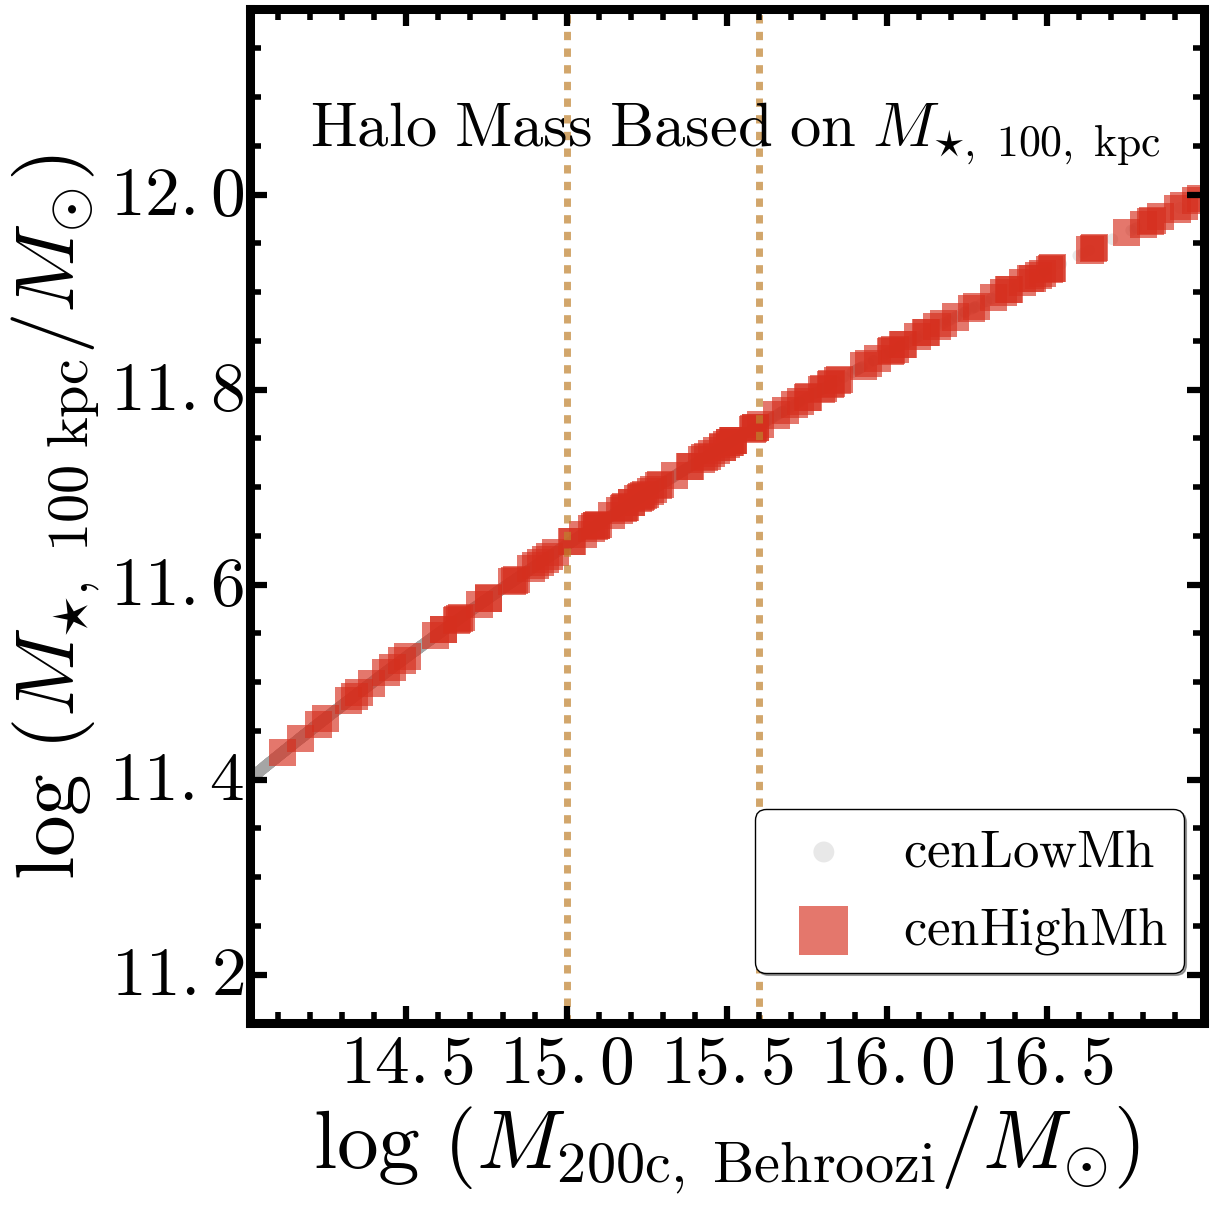

In [145]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.20, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonMhaloB0, nonbcgCleanU['logm_100'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redMhaloB0, redbcgCleanU['logm_100'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Behroozi}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{100\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 12.19)
ax1.set_xlim(14.01, 16.99)


ax1.text(14.20, 12.05, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{100,\ kpc}}$', 
         size=45)


# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_logm100_1.pdf'), dpi=150)

plt.show()

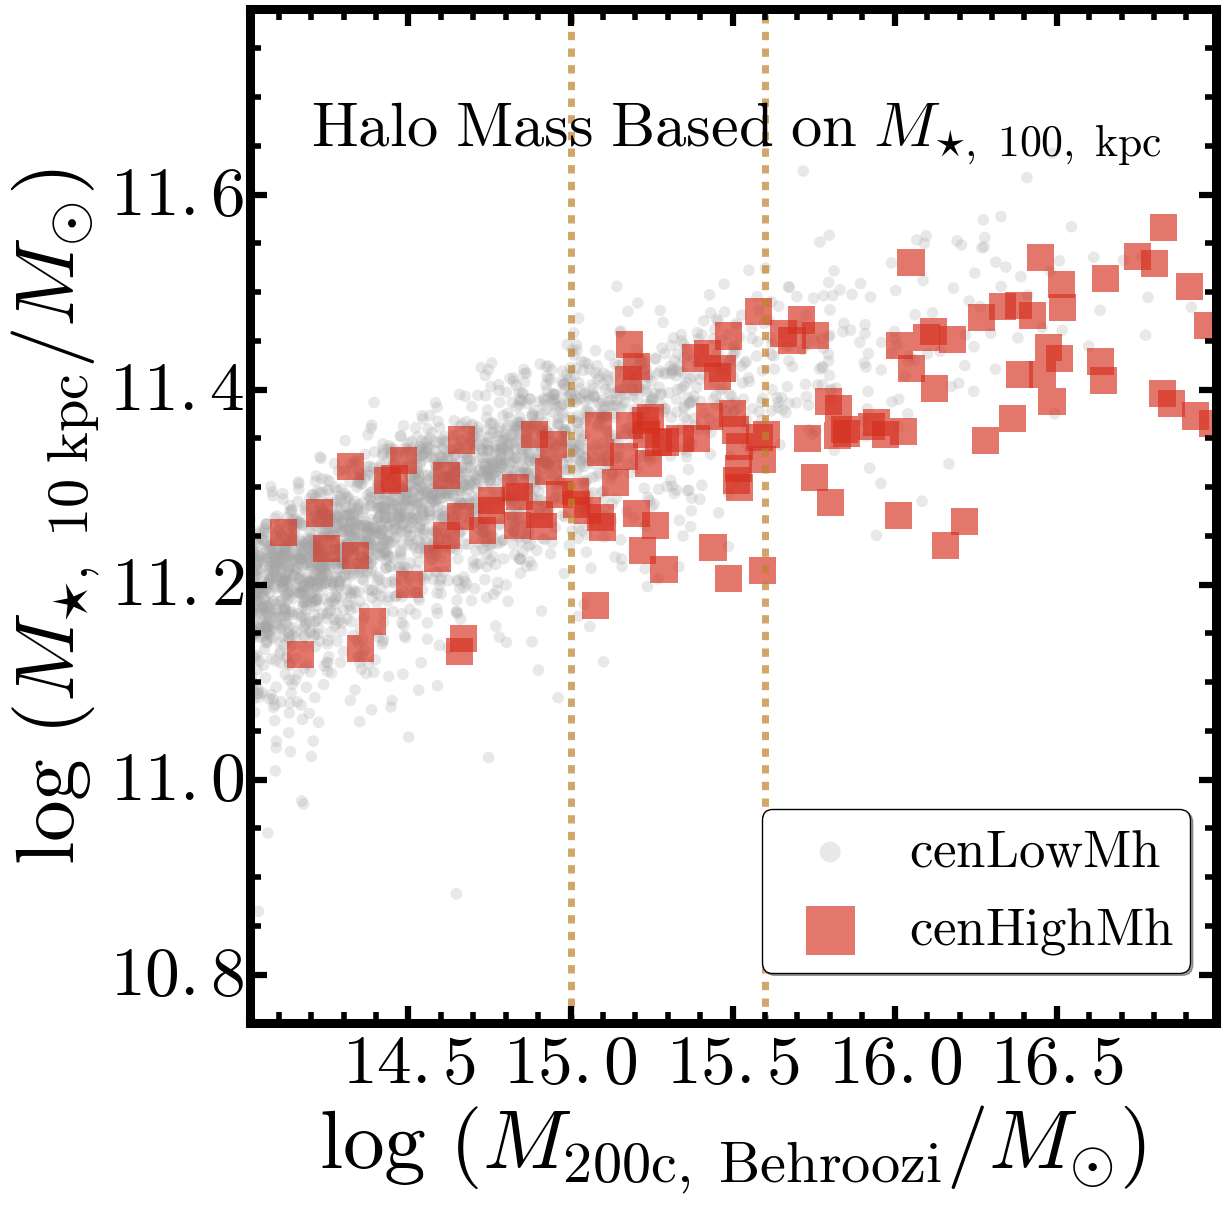

In [138]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonMhaloB0, nonbcgCleanU['logm_10'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redMhaloB0, redbcgCleanU['logm_10'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Behroozi}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{10\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(10.75, 11.79)
ax1.set_xlim(14.01, 16.99)

ax1.text(14.20, 11.65, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{100,\ kpc}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_logm10_1.pdf'), dpi=150)

plt.show()

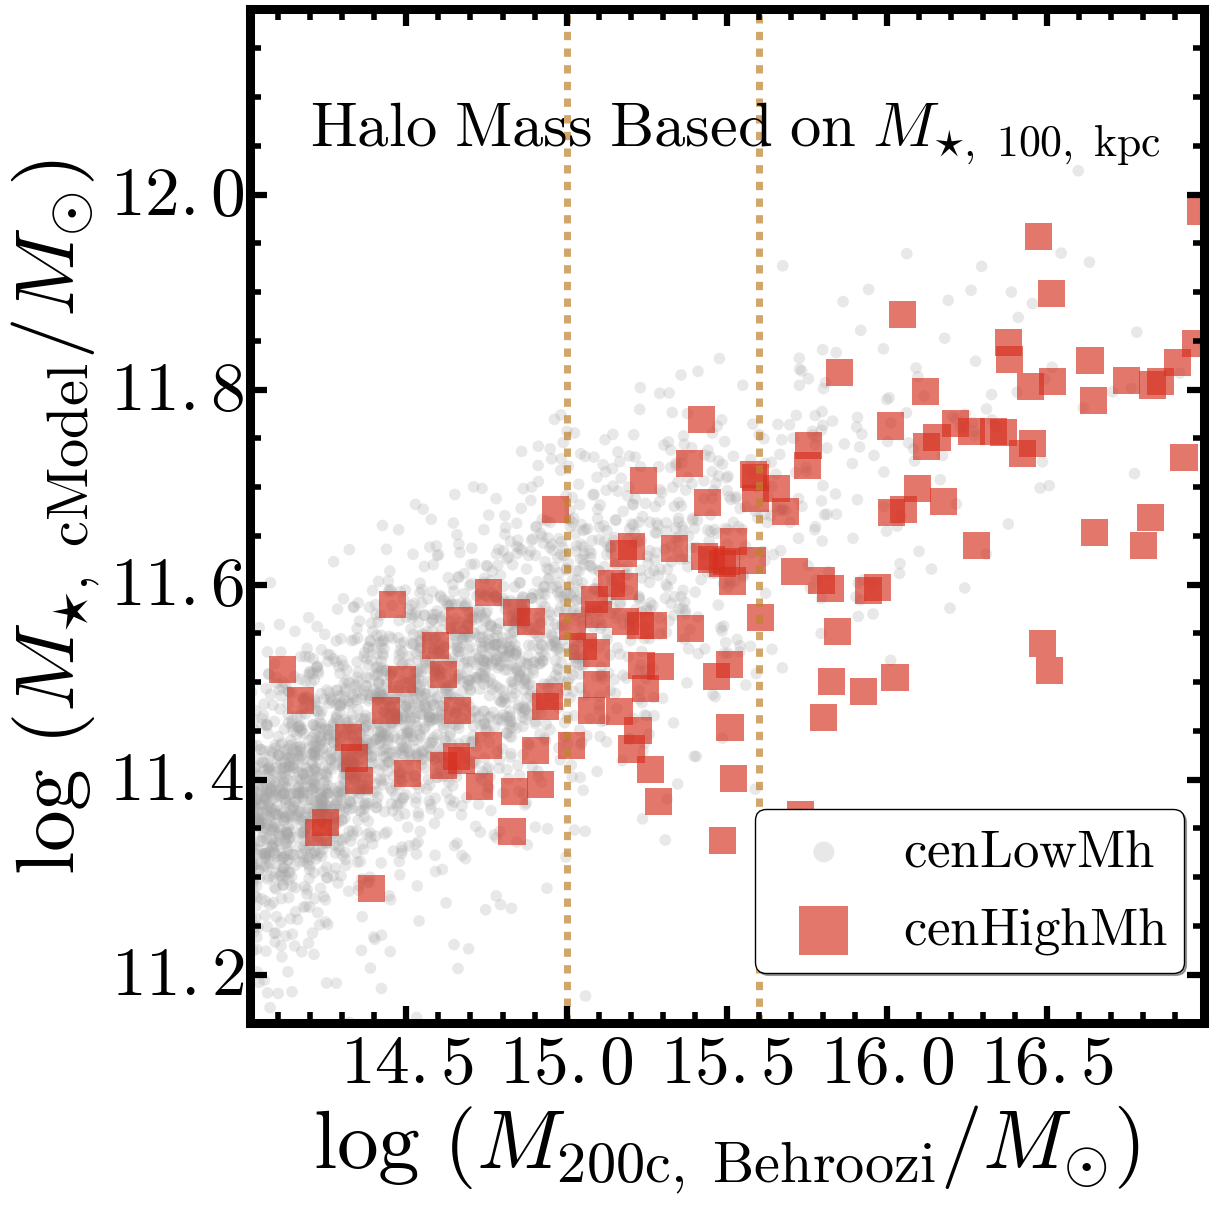

In [146]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.20, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonMhaloB0, nonbcgCleanU['MSTAR'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redMhaloB0, redbcgCleanU['MSTAR'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Behroozi}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{cModel}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 12.19)
ax1.set_xlim(14.01, 16.99)

ax1.text(14.20, 12.05, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{100,\ kpc}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_logmCmodel_1.pdf'), dpi=150)

plt.show()

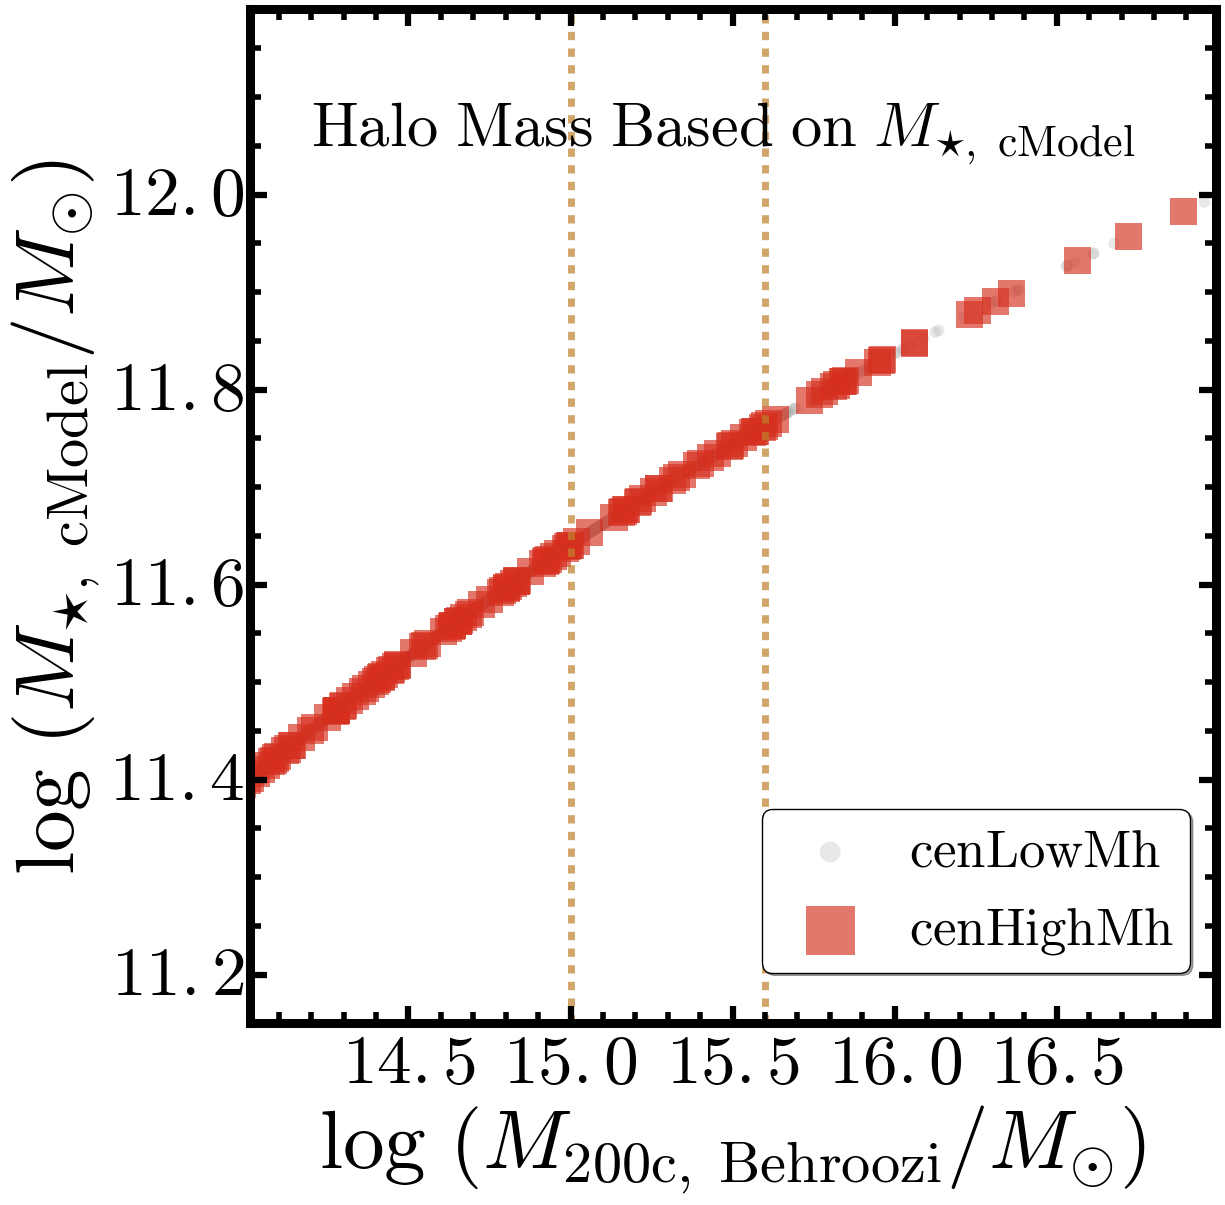

In [140]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonMhaloA0, nonbcgCleanU['MSTAR'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redMhaloA0, redbcgCleanU['MSTAR'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Behroozi}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{cModel}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 12.19)
ax1.set_xlim(14.01, 16.99)

ax1.text(14.20, 12.05, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{cModel}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_logmcModel_2.pdf'), dpi=150)

plt.show()

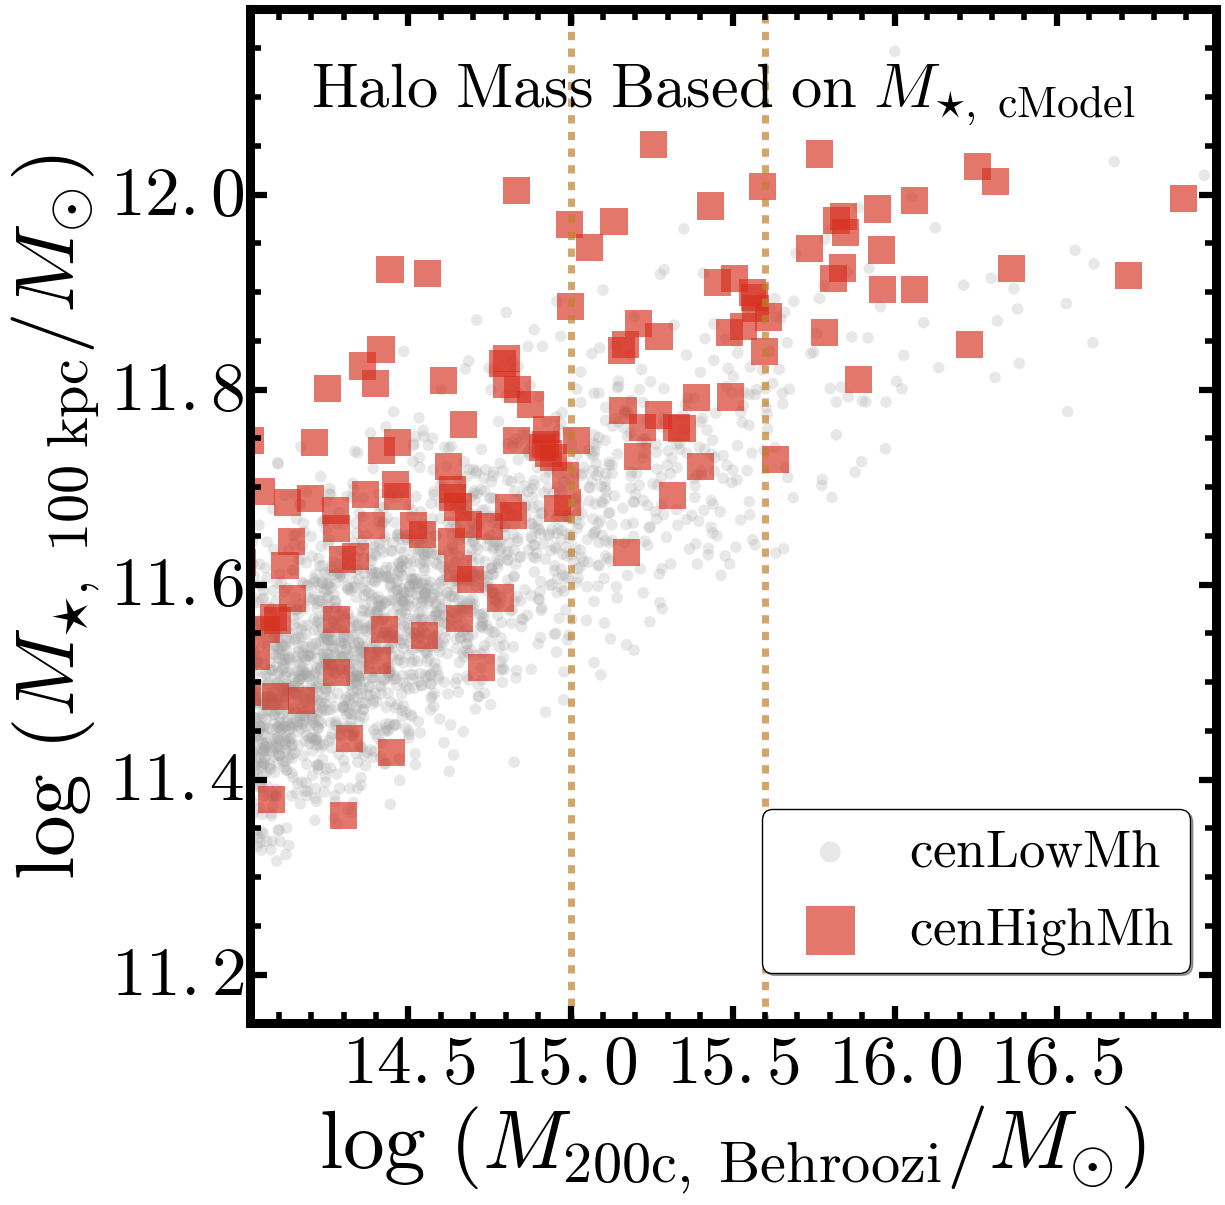

In [142]:
#-----------------------------------------------------------------#
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.15, top=0.995,
                    wspace=0.00, hspace=0.00)

ax1 = fig.add_subplot(111)
ax1 = songPlotSetup(ax1, xlabel=50, ylabel=50, border=6.5,
                    xtickFormat='$\mathrm{%4.1f}$', ytickFormat='$\mathrm{%3.1f}$')

ax1.scatter(nonMhaloA0, nonbcgCleanU['logm_100'],
            marker='o', edgecolor='none', cmap=ORG, s=70,
            c=BLK(0.45), 
            alpha=0.25, label='$\mathrm{cenLowMh}$',
            rasterized=True)
ax1.scatter(redMhaloA0, redbcgCleanU['logm_100'],
            marker='s', edgecolor='none', cmap=ORG, s=380,
            c=ORG(0.75), 
            alpha=0.65, label='$\mathrm{cenHighMh}$',
            rasterized=True)

# X, Y Label
ax1.set_xlabel('$\log\ ({M_{\mathrm{200c,\ Behroozi}}}/M_{\odot})$', 
               size=60)
ax1.set_ylabel('$\log\ ({M_{\star,\ \mathrm{100\ kpc}}}/M_{\odot})$', 
               size=60)

# X, Y limits
ax1.set_ylim(11.15, 12.19)
ax1.set_xlim(14.01, 16.99)

ax1.text(14.20, 12.09, '$\mathrm{Halo\ Mass\ Based\ on\ } M_{\star,\ \mathrm{cModel}}$', 
         size=45)

# Legend
l_handles, l_labels = ax1.get_legend_handles_labels()
ax1.legend(l_handles, l_labels, loc=(0.53, 0.05),
           shadow=True, fancybox=True, 
           numpoints=1, fontsize=38, scatterpoints=1, 
           markerscale=1.8, borderpad=0.3, handletextpad=0.5)
legend = ax1.get_legend()

ax1.axvline(15.00, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)
ax1.axvline(15.60, linestyle='--', linewidth=5.0, alpha=0.7, c=BROWN0)

#-----------------------------------------------------------------#
fig.savefig(os.path.join(figDir, 'redbcg_logmHalo_logm100_2.pdf'), dpi=150)

plt.show()

# Update the catalog

In [148]:
mhSimet, mhSimetU, mhSimetL = mhaloSimet(redbcgClean['lambda_redm'], h0=0.7)

r200m = mass_so.M_to_R((10.0 ** mhSimet), redbcgClean['z_use'], '200m')

In [151]:
redbcgClean.add_column(Column(mhSimet, name='logmh_simet'))
redbcgClean.add_column(Column(mhSimetU, name='logmh_simetU'))
redbcgClean.add_column(Column(mhSimetL, name='logmh_simetL'))
redbcgClean.add_column(Column(r200m, name='r200m_kpc'))

In [152]:
redbcgClean.write(os.path.join(sampleDir, redbcgFile.replace('.fits', '_clean.fits')), 
                  format='fits', overwrite=True)

In [153]:
mhSimet2, mhSimet2U, mhSimet2L = mhaloSimet(redbcgUse['lambda_redm'], h0=0.7)

r200m2 = mass_so.M_to_R((10.0 ** mhSimet2), redbcgUse['z_use'], '200m')

In [154]:
redbcgUse.add_column(Column(mhSimet2, name='logmh_simet'))
redbcgUse.add_column(Column(mhSimet2U, name='logmh_simetU'))
redbcgUse.add_column(Column(mhSimet2L, name='logmh_simetL'))
redbcgUse.add_column(Column(r200m2, name='r200m_kpc'))

In [155]:
redbcgUse.write(os.path.join(sampleDir, redbcgFile.replace('.fits', '_use.fits')), 
                format='fits', overwrite=True)